<a href="https://colab.research.google.com/github/tayfundaldik/Knee_Arthiritis_Detection/blob/main/Arthiritis_DetectionUnetVGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#U-net Training, Augmentation and Segmentation

##Importing Libraries

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import albumentations as A
from glob import glob
import shutil
from tqdm import tqdm
import json


##Data Preparation

In [ ]:
class PrepareData:
    def __init__(self, base_path, output_path):
        self.base_path = base_path
        self.output_path = output_path
        self.image_size = (256, 256)

        os.makedirs(f"{output_path}/train/images", exist_ok=True)
        os.makedirs(f"{output_path}/train/masks", exist_ok=True)

    def collect_data_pairs(self):
        data_pairs = []

        folders = ['HASTA_SAG', 'HASTA_SOL', 'KONTROL_SAG', 'KONTROL_SOL']

        for folder in folders:
            image_path = os.path.join(self.base_path, folder, 'usg')
            mask_path = os.path.join(self.base_path, folder, 'ROI')

            if os.path.exists(image_path) and os.path.exists(mask_path):
                image_files = glob(os.path.join(image_path, '*.png'))

                for img_file in image_files:
                    img_name = os.path.basename(img_file)
                    mask_name = img_name.replace('image_', 'mask_')
                    mask_file = os.path.join(mask_path, mask_name)

                    if os.path.exists(mask_file):
                        parts = img_name.replace('image_', '').replace('.png', '').split('_')
                        patient_id = parts[0]
                        side = parts[1]
                        condition = parts[2]
                        photo_num = parts[3]

                        data_pairs.append({
                            'image_path': img_file,
                            'mask_path': mask_file,
                            'patient_id': patient_id,
                            'side': side,
                            'condition': condition,
                            'photo_num': photo_num,
                            'category': folder
                        })

        return data_pairs

    def split_data_by_patient(self, data_pairs, test_size=0.2):
        patient_ids = list(set([pair['patient_id'] for pair in data_pairs]))

        train_val_patients, test_patients = train_test_split(
            patient_ids, test_size=test_size, random_state=42
        )

        train_val_pairs = [pair for pair in data_pairs if pair['patient_id'] in train_val_patients]
        test_pairs = [pair for pair in data_pairs if pair['patient_id'] in test_patients]

        return train_val_pairs, test_pairs

    def preprocess_image(self, image_path, mask_path):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, self.image_size)
        image = image.astype(np.float32) / 255.0

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, self.image_size)
        mask = (mask > 127).astype(np.float32)

        return image, mask

    def save_processed_data(self, data_pairs, split_name):
        for i, pair in enumerate(tqdm(data_pairs, desc=f"Processing {split_name}")):
            try:
                image, mask = self.preprocess_image(pair['image_path'], pair['mask_path'])

                filename = f"{pair['patient_id']}_{pair['side']}_{pair['condition']}_{pair['photo_num']}"

                np.save(f"{self.output_path}/{split_name}/images/{filename}.npy", image)
                np.save(f"{self.output_path}/{split_name}/masks/{filename}.npy", mask)

            except Exception as e:
                print(f"Error processing {pair['image_path']}: {e}")

    def prepare_dataset_for_kfold(self):
        print("Collecting Data Pairs")
        data_pairs = self.collect_data_pairs()
        print(f"Found {len(data_pairs)} data pairs.")

        print("Splitting Data")
        train_val_pairs, test_pairs = self.split_data_by_patient(data_pairs)

        print(f"Train+Val: {len(train_val_pairs)}, Test: {len(test_pairs)}")

        print("Saving train/val data...")
        self.save_processed_data(train_val_pairs, 'train')


        metadata = {
            'train_val_count': len(train_val_pairs),
            'test_count': len(test_pairs),
            'image_size': self.image_size
        }

        with open(f"{self.output_path}/metadata.json", 'w') as f:
            json.dump(metadata, f, indent=2)

        print("Data Preparation for K-fold is completed.")
        return train_val_pairs, test_pairs

##Augmentation

In [ ]:
class AugDataGen(tf.keras.utils.Sequence):
    def __init__(self, data_pairs=None, data_path=None, batch_size=8, shuffle=True, augment=False, image_size=(256, 256)):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.image_size = image_size

        if data_pairs is not None:
            self.data_pairs = data_pairs
        elif data_path is not None:
            self.image_files = glob(os.path.join(data_path, 'images', '*.npy'))
            self.mask_files = [f.replace('images', 'masks') for f in self.image_files]
            self.data_pairs = None
        else:
            raise ValueError("Either data_pairs or data_path must be provided")

        if self.data_pairs is not None:
            self.indexes = np.arange(len(self.data_pairs))
        else:
            self.indexes = np.arange(len(self.image_files))

        #Augmentation Pipeline#
        if augment:
            self.transform = A.Compose([
                A.Rotate(limit=15, p=0.5),
                A.HorizontalFlip(p=0.5),
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
                A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
                A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),
                A.GridDistortion(p=0.3),
            ])
        else:
            self.transform = None

        if shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        if self.data_pairs is not None:
            return len(self.data_pairs) // self.batch_size
        else:
            return len(self.image_files) // self.batch_size
    #Preprocessing#
    def preprocess_image(self, image_path, mask_path):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, self.image_size)
        image = image.astype(np.float32) / 255.0

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, self.image_size)
        mask = (mask > 127).astype(np.float32)

        return image, mask

    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_images = []
        batch_masks = []

        for i in batch_indexes:
            if self.data_pairs is not None:
                pair = self.data_pairs[i]
                image, mask = self.preprocess_image(pair['image_path'], pair['mask_path'])
            else:
                image = np.load(self.image_files[i])
                mask = np.load(self.mask_files[i])

            #Augmentation#
            if self.transform:
                img_uint8 = (image * 255).astype(np.uint8)
                mask_uint8 = (mask * 255).astype(np.uint8)

                transformed = self.transform(image=img_uint8, mask=mask_uint8)
                image = transformed['image'].astype(np.float32) / 255.0
                mask = transformed['mask'].astype(np.float32) / 255.0

            image = np.expand_dims(image, axis=-1)
            mask = np.expand_dims(mask, axis=-1)

            batch_images.append(image)
            batch_masks.append(mask)

        return np.array(batch_images), np.array(batch_masks)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

##Building U-Net

In [ ]:
#U-Net Layers#
def build_unet(input_shape=(256, 256, 1)):
    inputs = layers.Input(input_shape)

    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = layers.Dropout(0.5)(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = layers.Dropout(0.5)(conv5)
    up6 = layers.Conv2D(512, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(drop5))
    merge6 = layers.concatenate([drop4, up6], axis=3)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv2D(256, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv6))
    merge7 = layers.concatenate([conv3, up7], axis=3)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = layers.Conv2D(128, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv7))
    merge8 = layers.concatenate([conv2, up8], axis=3)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = layers.Conv2D(64, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv8))
    merge9 = layers.concatenate([conv1, up9], axis=3)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    return model

#Dice Score#
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

##Segmentation, K-Fold Validation and Training

In [ ]:
class SegmentFoldTrain:
    def __init__(self, train_val_pairs, test_pairs, k_folds=5, model_save_path="models_kfold/"):
        self.train_val_pairs = train_val_pairs
        self.test_pairs = test_pairs
        self.k_folds = k_folds
        self.model_save_path = model_save_path
        os.makedirs(model_save_path, exist_ok=True)

        self.patient_ids = list(set([pair['patient_id'] for pair in train_val_pairs]))
        self.kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

        self.fold_results = []

    def train_fold(self, fold_num, train_pairs, val_pairs, epochs=200):
        print(f"\n{'='*20} FOLD {fold_num + 1}/{self.k_folds} {'='*20}")
        print(f"Train samples: {len(train_pairs)}, Validation samples: {len(val_pairs)}")

        train_gen = AugDataGen(
            data_pairs=train_pairs,
            batch_size=8,
            shuffle=True,
            augment=True
        )
        val_gen = AugDataGen(
            data_pairs=val_pairs,
            batch_size=8,
            shuffle=False,
            augment=False
        )

        model = build_unet()
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss=combined_loss,
            metrics=['accuracy', dice_coefficient]
        )

        callbacks = [
            ModelCheckpoint(
                f"{self.model_save_path}/fold_{fold_num + 1}_best_model.h5",
                monitor='val_dice_coefficient',
                save_best_only=True,
                mode='max',
                verbose=0
            ),
            EarlyStopping(
                monitor='val_dice_coefficient',
                patience=15,
                mode='max',
                verbose=0
            ),
            ReduceLROnPlateau(
                monitor='val_dice_coefficient',
                factor=0.5,
                patience=10,
                mode='max',
                min_lr=1e-7,
                verbose=0
            )
        ]

        history = model.fit(
            train_gen,
            validation_data=val_gen,
            epochs=epochs,
            callbacks=callbacks,
            verbose=0
        )

        best_model = tf.keras.models.load_model(
            f"{self.model_save_path}/fold_{fold_num + 1}_best_model.h5",
            custom_objects={
                'combined_loss': combined_loss,
                'dice_coefficient': dice_coefficient
            }
        )

        val_results = best_model.evaluate(val_gen, verbose=0)

        fold_result = {
            'fold': fold_num + 1,
            'val_loss': val_results[0],
            'val_accuracy': val_results[1],
            'val_dice': val_results[2],
            'history': history.history
        }

        print(f"Fold {fold_num + 1} Results:")
        print(f"  Val Loss: {val_results[0]:.4f}")
        print(f"  Val Accuracy: {val_results[1]:.4f}")
        print(f"  Val Dice: {val_results[2]:.4f}")

        return fold_result, best_model

    def train_k_fold(self, epochs=200):
        print(f"Starting {self.k_folds}-Fold Cross Validation")
        print(f"Total patients: {len(self.patient_ids)}")

        best_models = []

        for fold_num, (train_idx, val_idx) in enumerate(self.kfold.split(self.patient_ids)):
            train_patients = [self.patient_ids[i] for i in train_idx]
            val_patients = [self.patient_ids[i] for i in val_idx]

            train_pairs = [pair for pair in self.train_val_pairs if pair['patient_id'] in train_patients]
            val_pairs = [pair for pair in self.train_val_pairs if pair['patient_id'] in val_patients]

            fold_result, best_model = self.train_fold(fold_num, train_pairs, val_pairs, epochs)
            self.fold_results.append(fold_result)
            best_models.append(best_model)

        val_losses = [result['val_loss'] for result in self.fold_results]
        val_accuracies = [result['val_accuracy'] for result in self.fold_results]
        val_dices = [result['val_dice'] for result in self.fold_results]

        print(f"\n{'='*50}")
        print("K-FOLD CROSS VALIDATION RESULTS")
        print(f"{'='*50}")
        print(f"Validation Loss:     {np.mean(val_losses):.4f} ± {np.std(val_losses):.4f}")
        print(f"Validation Accuracy: {np.mean(val_accuracies):.4f} ± {np.std(val_accuracies):.4f}")
        print(f"Validation Dice:     {np.mean(val_dices):.4f} ± {np.std(val_dices):.4f}")

        summary = {
            'k_folds': self.k_folds,
            'mean_val_loss': float(np.mean(val_losses)),
            'std_val_loss': float(np.std(val_losses)),
            'mean_val_accuracy': float(np.mean(val_accuracies)),
            'std_val_accuracy': float(np.std(val_accuracies)),
            'mean_val_dice': float(np.mean(val_dices)),
            'std_val_dice': float(np.std(val_dices)),
            'fold_results': self.fold_results
        }

        with open(f"{self.model_save_path}/kfold_results.json", 'w') as f:
            json.dump(summary, f, indent=2)

        return best_models, summary

    #Plotting Results#
    def plot_kfold_results(self):
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        folds = [result['fold'] for result in self.fold_results]
        val_losses = [result['val_loss'] for result in self.fold_results]
        val_accuracies = [result['val_accuracy'] for result in self.fold_results]
        val_dices = [result['val_dice'] for result in self.fold_results]

        axes[0, 0].bar(folds, val_losses, color='red', alpha=0.7)
        axes[0, 0].set_title('Validation Loss by Fold')
        axes[0, 0].set_xlabel('Fold')
        axes[0, 0].set_ylabel('Loss')

        axes[0, 1].bar(folds, val_accuracies, color='blue', alpha=0.7)
        axes[0, 1].set_title('Validation Accuracy by Fold')
        axes[0, 1].set_xlabel('Fold')
        axes[0, 1].set_ylabel('Accuracy')

        axes[1, 0].bar(folds, val_dices, color='green', alpha=0.7)
        axes[1, 0].set_title('Validation Dice by Fold')
        axes[1, 0].set_xlabel('Fold')
        axes[1, 0].set_ylabel('Dice Coefficient')

        if len(self.fold_results) > 0:
            history = self.fold_results[0]['history']
            epochs = range(1, len(history['loss']) + 1)

            axes[1, 1].plot(epochs, history['loss'], 'b-', label='Train Loss')
            axes[1, 1].plot(epochs, history['val_loss'], 'r-', label='Val Loss')
            axes[1, 1].set_title('Training History (Fold 1)')
            axes[1, 1].set_xlabel('Epoch')
            axes[1, 1].set_ylabel('Loss')
            axes[1, 1].legend()

        plt.tight_layout()
        plt.savefig(f"{self.model_save_path}/kfold_results.png", dpi=300, bbox_inches='tight')
        plt.show()

    def evaluate_on_test(self, best_models):
        print(f"\n{'='*50}")
        print("TEST SET EVALUATION")
        print(f"{'='*50}")

        test_gen = AugDataGen(
            data_pairs=self.test_pairs,
            batch_size=8,
            shuffle=False,
            augment=False
        )

        test_results = []
        all_predictions = []

        for i, model in enumerate(best_models):
            results = model.evaluate(test_gen, verbose=0)
            test_results.append({
                'fold': i + 1,
                'test_loss': results[0],
                'test_accuracy': results[1],
                'test_dice': results[2]
            })

            predictions = []
            for j in range(len(test_gen)):
                batch_images, _ = test_gen[j]
                pred = model.predict(batch_images, verbose=0)
                predictions.extend(pred)
            all_predictions.append(predictions)

            print(f"Fold {i + 1} Test Results:")
            print(f"  Loss: {results[0]:.4f}, Accuracy: {results[1]:.4f}, Dice: {results[2]:.4f}")

        ensemble_predictions = np.mean(all_predictions, axis=0)

        #Ground truth#
        all_true_masks = []
        for j in range(len(test_gen)):
            _, batch_masks = test_gen[j]
            all_true_masks.extend(batch_masks)
        all_true_masks = np.array(all_true_masks)

        #Binary predictions#
        pred_binary = (ensemble_predictions > 0.3).astype(np.uint8)
        true_binary = all_true_masks.astype(np.uint8)

        #Dice coefficient#
        intersection = np.sum(pred_binary * true_binary)
        ensemble_dice = 2 * intersection / (np.sum(pred_binary) + np.sum(true_binary))

        mean_test_loss = np.mean([r['test_loss'] for r in test_results])
        mean_test_accuracy = np.mean([r['test_accuracy'] for r in test_results])
        mean_test_dice = np.mean([r['test_dice'] for r in test_results])

        print(f"\nMean Test Results:")
        print(f"  Loss: {mean_test_loss:.4f} ± {np.std([r['test_loss'] for r in test_results]):.4f}")
        print(f"  Accuracy: {mean_test_accuracy:.4f} ± {np.std([r['test_accuracy'] for r in test_results]):.4f}")
        print(f"  Dice: {mean_test_dice:.4f} ± {np.std([r['test_dice'] for r in test_results]):.4f}")
        print(f"\nEnsemble Dice: {ensemble_dice:.4f}")

        return test_results, ensemble_dice

##Running Saved U-Net Model and Plotting

Data Preparation for K-Fold Cross Validation
Found 699 data pairs.
Splitting Data
Train+Val: 549, Test: 150
Saving train/val data...


Processing train: 100%|██████████| 549/549 [00:08<00:00, 67.08it/s]
/tmp/ipython-input-19-177491622.py:157: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
/tmp/ipython-input-19-177491622.py:158: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Data Preparation for K-fold is completed.

Starting K-Fold Cross Validation Training
Starting 5-Fold Cross Validation
Total patients: 20

==================== FOLD 1/5 ====================
Train samples: 449, Validation samples: 100


Fold 1 Results:
  Val Loss: 0.2472
  Val Accuracy: 0.9890
  Val Dice: 0.7985

==================== FOLD 2/5 ====================
Train samples: 469, Validation samples: 80


Fold 2 Results:
  Val Loss: 0.2869
  Val Accuracy: 0.9915
  Val Dice: 0.7426

==================== FOLD 3/5 ====================
Train samples: 429, Validation samples: 120


Fold 3 Results:
  Val Loss: 0.3013
  Val Accuracy: 0.9890
  Val Dice: 0.7471

==================== FOLD 4/5 ====================
Train samples: 400, Validation samples: 149


Fold 4 Results:
  Val Loss: 0.2432
  Val Accuracy: 0.9907
  Val Dice: 0.8000

==================== FOLD 5/5 ====================
Train samples: 449, Validation samples: 100


Fold 5 Results:
  Val Loss: 0.2262
  Val Accuracy: 0.9894
  Val Dice: 0.8115

K-FOLD CROSS VALIDATION RESULTS
Validation Loss:     0.2610 ± 0.0283
Validation Accuracy: 0.9899 ± 0.0010
Validation Dice:     0.7799 ± 0.0290


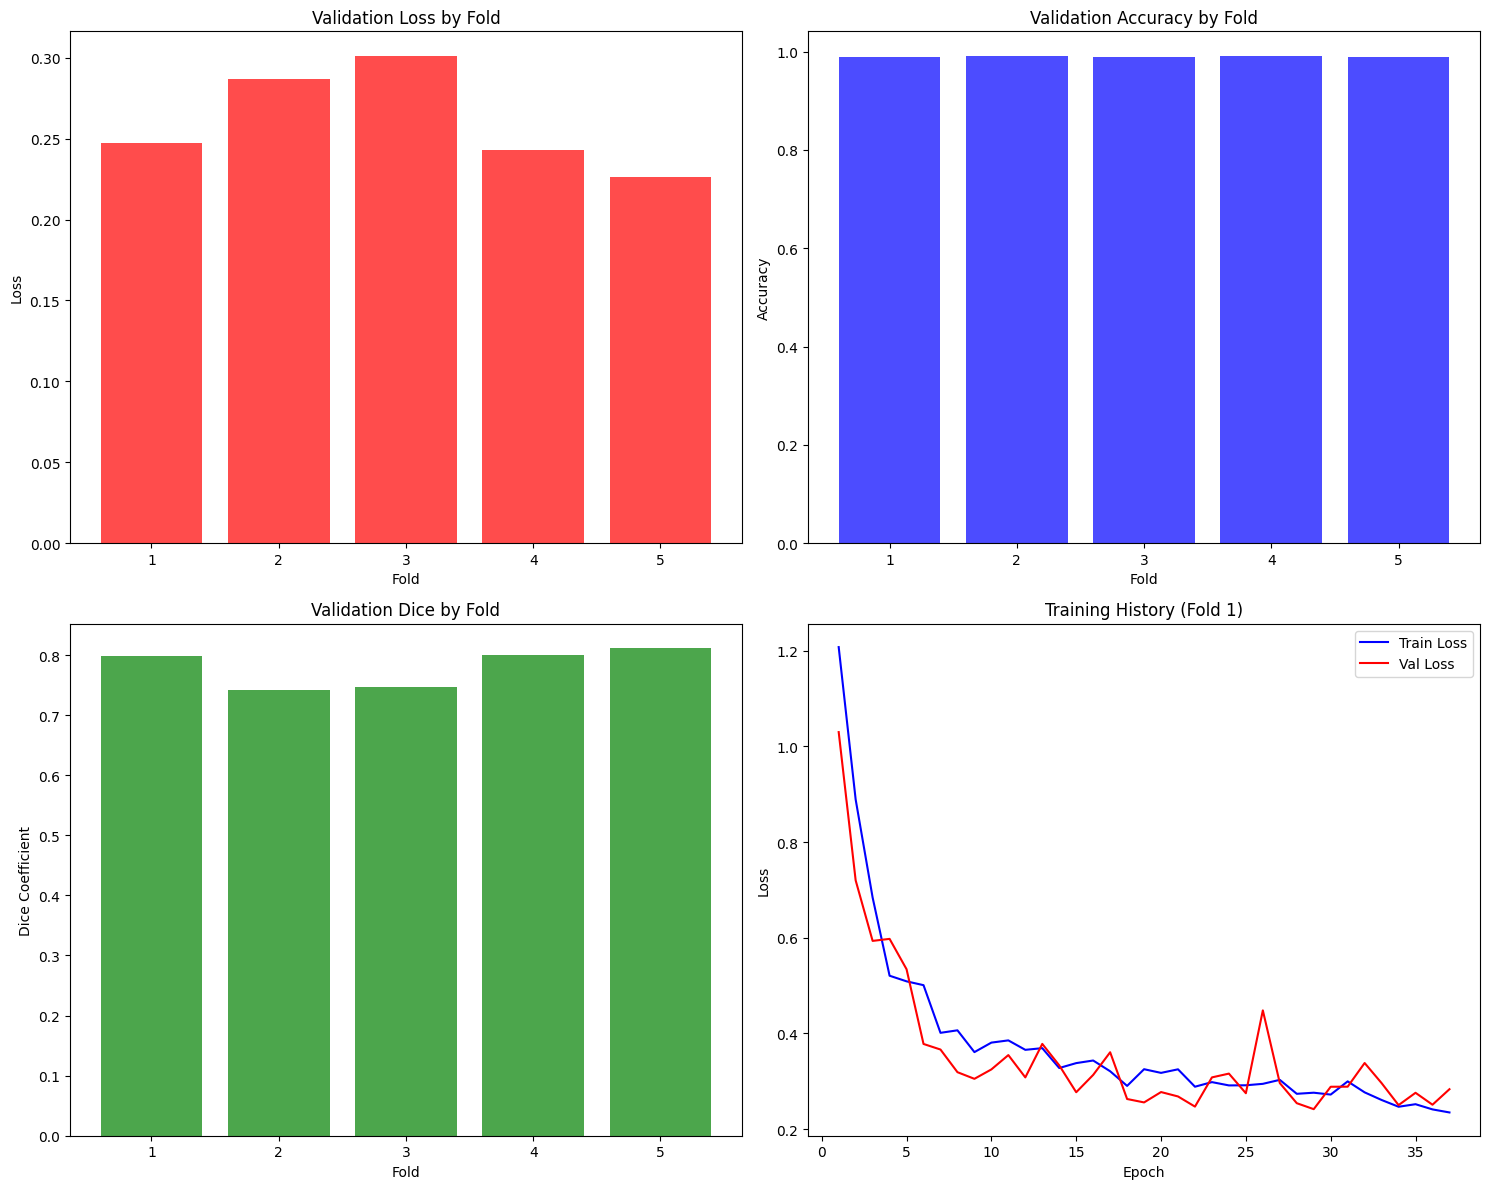


TEST SET EVALUATION
Fold 1 Test Results:
  Loss: 0.2842, Accuracy: 0.9880, Dice: 0.7718
Fold 2 Test Results:
  Loss: 0.2533, Accuracy: 0.9898, Dice: 0.7931
Fold 3 Test Results:
  Loss: 0.3252, Accuracy: 0.9875, Dice: 0.7439
Fold 4 Test Results:
  Loss: 0.2423, Accuracy: 0.9902, Dice: 0.8097
Fold 5 Test Results:
  Loss: 0.2792, Accuracy: 0.9885, Dice: 0.7705

Mean Test Results:
  Loss: 0.2768 ± 0.0288
  Accuracy: 0.9888 ± 0.0010
  Dice: 0.7778 ± 0.0223

Ensemble Dice: 0.8277

K-Fold Cross Validation completed!
Best CV Dice Score: 0.7799 ± 0.0290
Test Ensemble Dice: 0.8277


In [ ]:
if __name__ == "__main__":
    # Data Preparation for K-Fold Cross Validation#
    print("Data Preparation for K-Fold Cross Validation")
    preparator = PrepareData(
        base_path="/content/dizeklem/diz_eklem",
        output_path="processed_data2"
    )

    train_val_pairs, test_pairs = preparator.prepare_dataset_for_kfold()

    print("\nStarting K-Fold Cross Validation Training")
    kfold_trainer = SegmentFoldTrain(
        train_val_pairs=train_val_pairs,
        test_pairs=test_pairs,
        k_folds=5,
        model_save_path="models_kfolds1"
    )

    best_models, cv_summary = kfold_trainer.train_k_fold(epochs=200)

    #Plot results#
    kfold_trainer.plot_kfold_results()

    #Evaluate on test set#
    test_results, ensemble_dice = kfold_trainer.evaluate_on_test(best_models)

    print("\nK-Fold Cross Validation completed!")
    print(f"Best CV Dice Score: {cv_summary['mean_val_dice']:.4f} ± {cv_summary['std_val_dice']:.4f}")
    print(f"Test Ensemble Dice: {ensemble_dice:.4f}")

#Feature Extraction and Classification with VGG16 and Random Forest

##Importing Libraries

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import albumentations as A
import cv2
import pickle

##Defining Preprocessing Data and Training Functions

In [4]:
class VGG16RFClassification:
    def __init__(self, input_shape=(224, 224, 3)):
        self.input_shape = input_shape
        self.model = self._feature_extractor()
        self.scaler = StandardScaler()
        self.augmentation_pipeline = self._augmentation()

    def _feature_extractor(self):

        base_model = VGG16(weights='imagenet', include_top=False, input_shape=self.input_shape)

        x = base_model.output
        x = tf.keras.layers.GlobalAveragePooling2D()(x)

        feature_extractor = Model(inputs=base_model.input, outputs=x)

        return feature_extractor

    def _augmentation(self):

        transform = A.Compose([
            A.OneOf([
                A.Rotate(limit=15, border_mode=cv2.BORDER_CONSTANT, value=0, p=0.6),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.3),
            ], p=0.7),

            A.OneOf([
                A.RandomBrightnessContrast(
                    brightness_limit=0.1,
                    contrast_limit=0.1,
                    p=0.6
                ),
                A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.4),
                A.RandomGamma(gamma_limit=(90, 110), p=0.3),
            ], p=0.5),

            A.OneOf([
                A.GaussNoise(var_limit=(5.0, 15.0), mean=0, p=0.3),
                A.GaussianBlur(blur_limit=(1, 3), sigma_limit=0, p=0.2),
                A.MotionBlur(blur_limit=3, p=0.2),
            ], p=0.3),

            A.OneOf([
                A.ElasticTransform(
                    alpha=1,
                    sigma=10,
                    alpha_affine=10,
                    border_mode=cv2.BORDER_CONSTANT,
                    value=0,
                    p=0.2
                ),
                A.GridDistortion(
                    num_steps=3,
                    distort_limit=0.05,
                    border_mode=cv2.BORDER_CONSTANT,
                    value=0,
                    p=0.2
                ),
            ], p=0.2),

        ], additional_targets={'mask': 'mask'})

        return transform

    def _apply_augment(self, image, mask):

        if image.dtype != np.uint8:
            if image.max() <= 1.0:
                image_uint8 = (image * 255).astype(np.uint8)
            else:
                image_uint8 = ((image - image.min()) / (image.max() - image.min()) * 255).astype(np.uint8)
        else:
            image_uint8 = image

        if mask.dtype != np.uint8:
            if mask.max() <= 1.0:
                mask_uint8 = (mask * 255).astype(np.uint8)
            else:
                mask_uint8 = ((mask - mask.min()) / (mask.max() - mask.min()) * 255).astype(np.uint8)
        else:
            mask_uint8 = mask

        if len(image_uint8.shape) == 2:
            image_uint8 = np.stack([image_uint8] * 3, axis=-1)
        elif len(image_uint8.shape) == 3 and image_uint8.shape[-1] == 1:
            image_uint8 = np.repeat(image_uint8, 3, axis=-1)

        if len(mask_uint8.shape) == 3:
            mask_uint8 = mask_uint8[:, :, 0]

        try:
            augmented = self.augmentation_pipeline(image=image_uint8, mask=mask_uint8)
            aug_image = augmented['image']
            aug_mask = augmented['mask']

            aug_image = aug_image.astype(np.float32) / 255.0
            aug_mask = aug_mask.astype(np.float32) / 255.0

            return aug_image, aug_mask

        except Exception as e:
            print(f"Augmentation Error: {e}")
            return image.astype(np.float32), mask.astype(np.float32)

    def _augment_data(self, images, masks, labels, file_names, augmentation_factor=2):

        print(f"Applying augmentaion... (Factor: {augmentation_factor})")
        aug_images = images.copy()
        aug_masks = masks.copy()
        aug_labels = labels.tolist()
        aug_names = file_names.copy()

        for i, (img, mask, label, name) in enumerate(zip(images, masks, labels, file_names)):
            for aug_idx in range(augmentation_factor):
                aug_img, aug_mask = self._apply_augment(img, mask)

                aug_images.append(aug_img)
                aug_masks.append(aug_mask)
                aug_labels.append(label)
                aug_names.append(f"{name}_albu_aug_{aug_idx}")

            if (i + 1) % 50 == 0:
                print(f"Augmentation: {i + 1}/{len(images)} completed")

        print(f"Augmentation process is completed. Total Image Count: {len(aug_images)} (Original Image Count: {len(images)})")

        aug_labels = np.array(aug_labels)

        return aug_images, aug_masks, aug_labels, aug_names

    def load_and_split_data(self, data_dir, test_size=0.2, random_state=42, apply_augmentation=True, augmentation_factor=2):

        images_dir = os.path.join(data_dir, 'train', 'images')
        masks_dir = os.path.join(data_dir, 'train', 'masks')

        image_files = glob.glob(os.path.join(images_dir, '*.npy'))
        image_files.sort()

        print(f"Total {len(image_files)} images found.")

        all_images = []
        all_masks = []
        all_labels = []
        all_file_names = []

        for image_file in image_files:
            try:
                base_name = os.path.basename(image_file)
                mask_file = os.path.join(masks_dir, base_name)

                if not os.path.exists(mask_file):
                    print(f"Warning: Couldn't find mask image for {base_name}, continuing.")
                    continue

                if 'C' in base_name.upper():
                    label = 0
                elif 'P' in base_name.upper():
                    label = 1
                else:
                    print(f"Warning: Couldn't find C or P in the '{base_name}' ")
                    continue

                image = np.load(image_file)
                mask = np.load(mask_file)

                all_images.append(image)
                all_masks.append(mask)
                all_labels.append(label)
                all_file_names.append(base_name)

            except Exception as e:
                print(f"Error: Error while processing{base_name}: {e}")
                continue

        if len(all_images) == 0:
            print("Failed to load any data!")
            return None, None, None, None

        all_labels = np.array(all_labels)

        print(f"Total Data Count: {len(all_images)}")
        print(f"Healthy (C): {np.sum(all_labels == 0)}")
        print(f"Diseased (P): {np.sum(all_labels == 1)}")

        train_indices, test_indices = train_test_split(
            range(len(all_images)),
            test_size=test_size,
            random_state=random_state,
            stratify=all_labels
        )

        train_images = [all_images[i] for i in train_indices]
        train_masks = [all_masks[i] for i in train_indices]
        train_labels = all_labels[train_indices]
        train_names = [all_file_names[i] for i in train_indices]

        test_images = [all_images[i] for i in test_indices]
        test_masks = [all_masks[i] for i in test_indices]
        test_labels = all_labels[test_indices]
        test_names = [all_file_names[i] for i in test_indices]

        print(f"\nTrain set: {len(train_images)} - Healthy: {np.sum(train_labels == 0)}, Diseased: {np.sum(train_labels == 1)}")
        print(f"Test set: {len(test_images)} - Healthy: {np.sum(test_labels == 0)}, Diseased: {np.sum(test_labels == 1)}")

        if apply_augmentation and len(train_images) > 0:
            train_images, train_masks, train_labels, train_names = self._augment_data(
                train_images, train_masks, train_labels, train_names, augmentation_factor
            )

        print("\nfeature extraction for train data...")
        train_features = self._extract_features_from_data(train_images, train_masks, train_names, "TRAIN")

        print("\nfeature extraction for test data...")
        test_features = self._extract_features_from_data(test_images, test_masks, test_names, "TEST")

        return train_features, test_features, train_labels, test_labels

    def _extract_features_from_data(self, images, masks, names, data_type="DATA"):

        features = []
        processed_count = 0

        for i, (image, mask, name) in enumerate(zip(images, masks, names)):
            try:
                feature = self._process_single_image(image, mask)

                if feature is not None:
                    features.append(feature)
                    processed_count += 1

                if (i + 1) % 100 == 0:
                    print(f"{data_type} feature extraction: {i + 1}/{len(images)}")

            except Exception as e:
                print(f"Error: Error during processing {name}: {e}")
                continue

        features = np.array(features)
        print(f"{data_type} feature extraction completed: {len(features)} examples")

        return features

    def _process_single_image(self, image, mask):

        try:
            segmented_image = self._apply_mask(image, mask)

            processed_image = self._prepare_for_vgg16(segmented_image)

            feature = self.model.predict(processed_image, verbose=0)

            return feature.flatten()

        except Exception as e:
            print(f"Image Processing Error: {e}")
            return None

    def _apply_mask(self, image, mask):

        if mask.max() > 1:
            mask = mask.astype(np.float32) / mask.max()

        if len(mask.shape) == 2:
            mask = np.stack([mask] * 3, axis=-1)
        elif len(mask.shape) == 3 and mask.shape[-1] == 1:
            mask = np.repeat(mask, 3, axis=-1)

        if len(image.shape) == 2:
            image = np.stack([image] * 3, axis=-1)
        elif len(image.shape) == 3 and image.shape[-1] == 1:
            image = np.repeat(image, 3, axis=-1)

        segmented_image = image * mask

        return segmented_image

    def _prepare_for_vgg16(self, image):

        if image.max() <= 1.0:
            image = image * 255.0
        image = image.astype(np.uint8)

        if image.shape[:2] != (224, 224):
            image_pil = Image.fromarray(image)
            image_resized = image_pil.resize((224, 224), Image.LANCZOS)
            image = np.array(image_resized)


        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image.astype(np.float32))

        return image

    def train_classifier(self, X_train, X_test, y_train, y_test, model_suffix='', random_state=42):

        if len(X_train) == 0:
            print("Error: No data for training!")
            return None, 0, None

        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        classifier = RandomForestClassifier(
            n_estimators=200,
            max_depth=15,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=random_state,
            n_jobs=-1,
            class_weight='balanced'
        )

        print(f"\nTraining RF classifier...")
        print(f"Train set: {len(X_train)} examples")
        print(f"Test set: {len(X_test)} examples")

        classifier.fit(X_train_scaled, y_train)

        y_pred = classifier.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)

        print(f"\nTest Accuracy: {accuracy:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=['Healthy (C)', 'Diseased (P)']))

        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Healthy (C)', 'Diseased (P)'],
                   yticklabels=['Healthy (C)', 'Diseased (P)'])
        plt.title(f'Random Forest Confusion Matrix {model_suffix}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.show()

        feature_importance = classifier.feature_importances_
        top_indices = np.argsort(feature_importance)[-20:]

        plt.figure(figsize=(10, 8))
        plt.barh(range(20), feature_importance[top_indices])
        plt.title('Top 20 Feature Importance')
        plt.xlabel('Importance')
        plt.ylabel('Feature Index')
        plt.tight_layout()
        plt.show()

        results = {
            'accuracy': accuracy,
            'train_size': len(X_train),
            'test_size': len(X_test),
            'confusion_matrix': cm,
            'classification_report': classification_report(y_test, y_pred, target_names=['Healthy (C)', 'Diseased (P)'], output_dict=True),
            'feature_importance': feature_importance
        }

        return classifier, accuracy, results

    def predict_new_sample(self, image_path, mask_path, classifier):

        try:
            image = np.load(image_path)
            mask = np.load(mask_path)

            feature = self._process_single_image(image, mask)

            if feature is None:
                return None, None

            feature = feature.reshape(1, -1)
            feature_scaled = self.scaler.transform(feature)

            prediction = classifier.predict(feature_scaled)[0]
            probability = classifier.predict_proba(feature_scaled)[0]

            return prediction, probability

        except Exception as e:
            print(f"Prediction error: {e}")
            return None, None


##Train and Saving the Model

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/tmp/ipython-input-4-3392556994.py:23: UserWarning: Argument(s) 'value' are not valid for transform Rotate
  A.Rotate(limit=15, border_mode=cv2.BORDER_CONSTANT, value=0, p=0.6),
/tmp/ipython-input-4-3392556994.py:39: UserWarning: Argument(s) 'var_limit, mean' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 15.0), mean=0, p=0.3),
/tmp/ipython-input-4-3392556994.py:45: UserWarning: Argument(s) 'alpha_affine, value' are not valid for transform ElasticTransform
  A.ElasticTransform(
/tmp/ipython-input-4-3392556994.py:53: UserWarning: Argument(s) 'value' are not valid for transform GridDistortion
  A.GridDistortion(


Applying augmentations...

Splitting and applying augmentations to data...
Total 549 images found.
Total Data Count: 549
Healthy (C): 350
Diseased (P): 199

Train set: 439 - Healthy: 280, Diseased: 159
Test set: 110 - Healthy: 70, Diseased: 40
Applying augmentaion... (Factor: 3)


/usr/local/lib/python3.11/dist-packages/albumentations/augmentations/blur/functional.py:416: RuntimeWarning: invalid value encountered in divide
  kernel_1d = np.exp(-0.5 * (x / sigma) ** 2)
/usr/local/lib/python3.11/dist-packages/albumentations/augmentations/blur/functional.py:416: RuntimeWarning: divide by zero encountered in divide
  kernel_1d = np.exp(-0.5 * (x / sigma) ** 2)


Augmentation: 50/439 completed
Augmentation: 100/439 completed
Augmentation: 150/439 completed
Augmentation: 200/439 completed
Augmentation: 250/439 completed
Augmentation: 300/439 completed
Augmentation: 350/439 completed
Augmentation: 400/439 completed
Augmentation process is completed. Total Image Count: 1756 (Original Image Count: 439)

feature extraction for train data...
TRAIN feature extraction: 100/1756
TRAIN feature extraction: 200/1756
TRAIN feature extraction: 300/1756
TRAIN feature extraction: 400/1756
TRAIN feature extraction: 500/1756
TRAIN feature extraction: 600/1756
TRAIN feature extraction: 700/1756
TRAIN feature extraction: 800/1756
TRAIN feature extraction: 900/1756
TRAIN feature extraction: 1000/1756
TRAIN feature extraction: 1100/1756
TRAIN feature extraction: 1200/1756
TRAIN feature extraction: 1300/1756
TRAIN feature extraction: 1400/1756
TRAIN feature extraction: 1500/1756
TRAIN feature extraction: 1600/1756
TRAIN feature extraction: 1700/1756
TRAIN feature ext

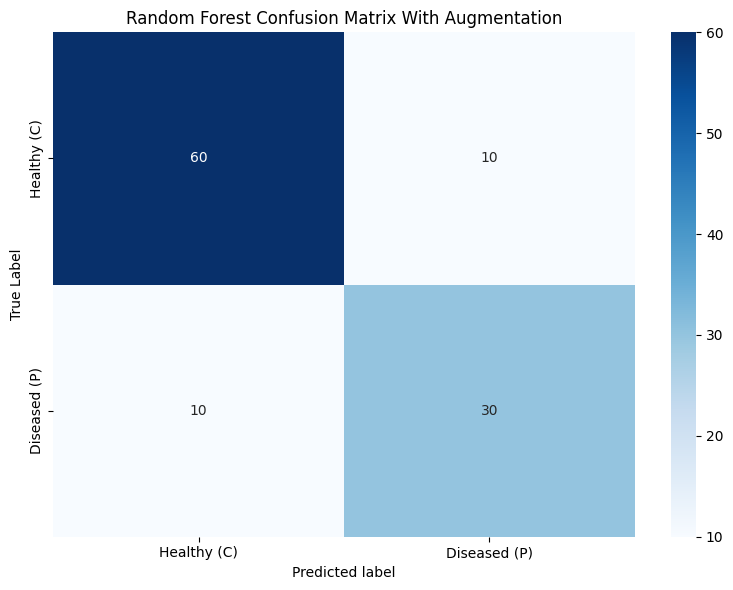

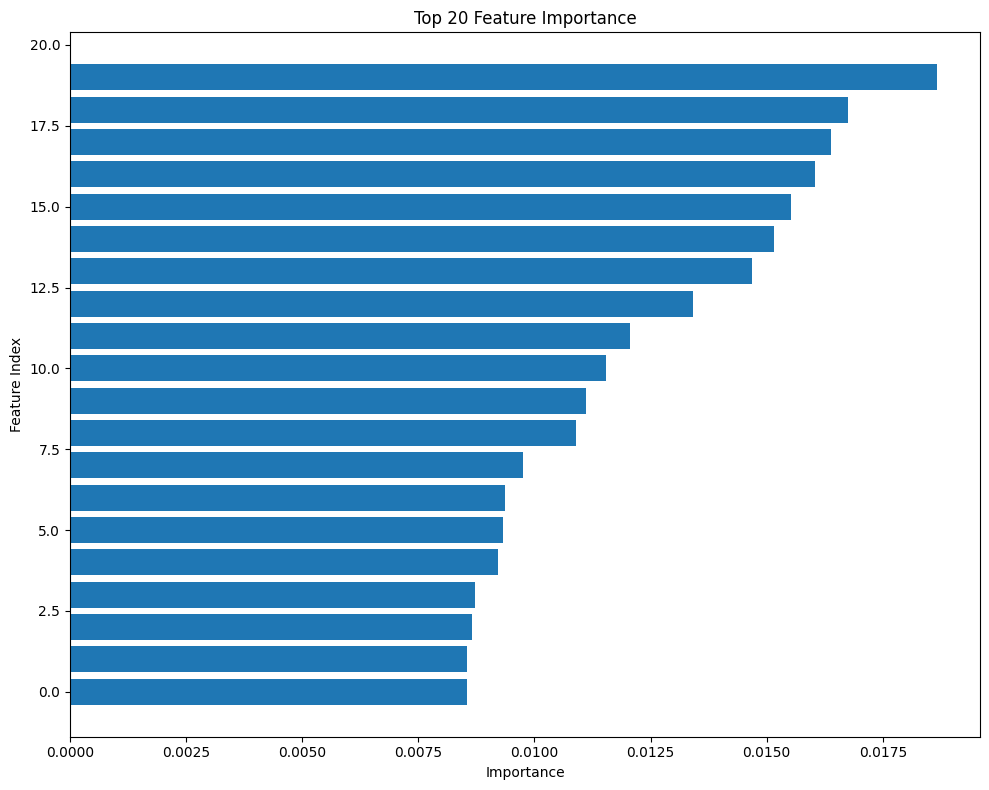


Accuracy: 0.8182
Model and scaler saved succesfully!

Without Augmentation
Total 549 images found.
Total Data Count: 549
Healthy (C): 350
Diseased (P): 199

Train set: 439 - Healthy: 280, Diseased: 159
Test set: 110 - Healthy: 70, Diseased: 40

feature extraction for train data...
TRAIN feature extraction: 100/439
TRAIN feature extraction: 200/439
TRAIN feature extraction: 300/439
TRAIN feature extraction: 400/439
TRAIN feature extraction completed: 439 examples

feature extraction for test data...
TEST feature extraction: 100/110
TEST feature extraction completed: 110 examples

Training RF classifier...
Train set: 439 examples
Test set: 110 examples

Test Accuracy: 0.8000

Classification Report:
              precision    recall  f1-score   support

 Healthy (C)       0.82      0.87      0.85        70
Diseased (P)       0.75      0.68      0.71        40

    accuracy                           0.80       110
   macro avg       0.79      0.77      0.78       110
weighted avg       0.

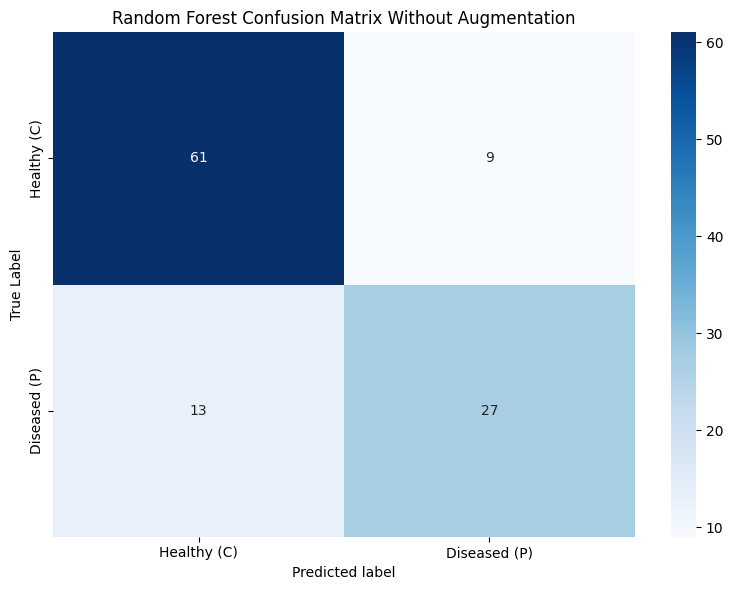

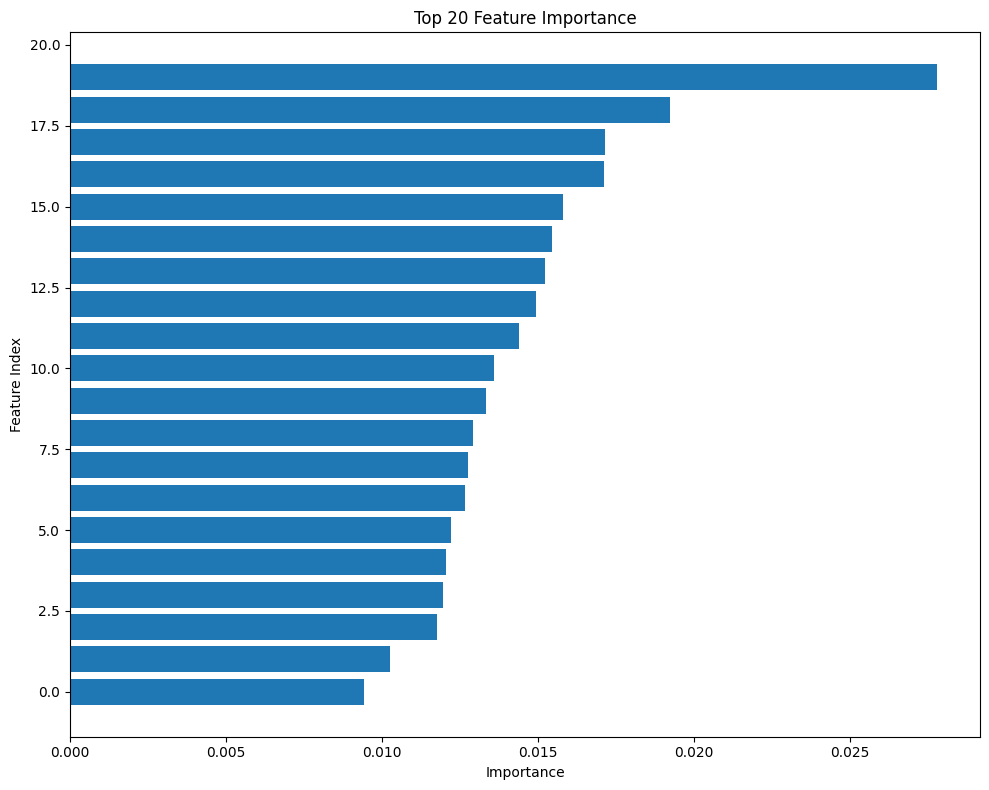


Comparison of Augmentation:
With Augmentation: 0.8182
Without Augmentation: 0.8000
Improvement: 0.0182
Improvement Percent: %2.27

Process completed!


In [5]:
def main():
    extractor = VGG16RFClassification()

    data_directory = "/content/drive/MyDrive/processed_data2x"

    print("Applying augmentations...")

    print("\nSplitting and applying augmentations to data...")
    train_features, test_features, train_labels, test_labels = extractor.load_and_split_data(
        data_directory,
        test_size=0.2,
        random_state=42,
        apply_augmentation=True,
        augmentation_factor=3
    )

    if train_features is None or len(train_features) == 0:
        print("No data could be processed. Please verify the folder structure.")
        return

    print("\nSaving results...")
    np.save("train_features_albumentations.npy", train_features)
    np.save("test_features_albumentations.npy", test_features)
    np.save("train_labels_albumentations.npy", train_labels)
    np.save("test_labels_albumentations.npy", test_labels)

    print("\n" + "="*60)
    print("With Augmentation")
    print("="*60)

    rf_classifier, rf_accuracy, rf_results = extractor.train_classifier(
        train_features, test_features, train_labels, test_labels,
        model_suffix="With Augmentation"
    )

    with open('rf_vgg16_classifier_albumentations.pkl', 'wb') as f:
        pickle.dump(rf_classifier, f)
    with open('vgg16_scaler_albumentations.pkl', 'wb') as f:
        pickle.dump(extractor.scaler, f)

    print(f"\nAccuracy: {rf_accuracy:.4f}")
    print("Model and scaler saved succesfully!")

    print("\n" + "="*60)
    print("Without Augmentation")
    print("="*60)

    train_features_no_aug, test_features_no_aug, train_labels_no_aug, test_labels_no_aug = extractor.load_and_split_data(
        data_directory,
        test_size=0.2,
        random_state=42,
        apply_augmentation=False
    )

    if train_features_no_aug is not None:
        rf_classifier_no_aug, rf_accuracy_no_aug, _ = extractor.train_classifier(
            train_features_no_aug, test_features_no_aug, train_labels_no_aug, test_labels_no_aug,
            model_suffix="Without Augmentation"
        )
        print(f"\nComparison of Augmentation:")
        print(f"With Augmentation: {rf_accuracy:.4f}")
        print(f"Without Augmentation: {rf_accuracy_no_aug:.4f}")
        print(f"Improvement: {rf_accuracy - rf_accuracy_no_aug:.4f}")

        improvement_percent = ((rf_accuracy - rf_accuracy_no_aug) / rf_accuracy_no_aug) * 100
        print(f"Improvement Percent: %{improvement_percent:.2f}")

    print("\nProcess completed!")

def analyze_augmentations():
    extractor = VGG16RFClassification()

    try:
        test_image = "/content/drive/MyDrive/processed_data2x/train/images/005_L_C_001.npy"
        test_mask = "/content/drive/MyDrive/processed_data2x/train/masks/005_L_C_001.npy"

        image = np.load(test_image)
        mask = np.load(test_mask)

        fig, axes = plt.subplots(2, 4, figsize=(16, 8))

        axes[0, 0].imshow(image, cmap='gray')
        axes[0, 0].set_title('Original Image')
        axes[0, 0].axis('off')

        axes[1, 0].imshow(mask, cmap='gray')
        axes[1, 0].set_title('Original Mask')
        axes[1, 0].axis('off')

        for i in range(3):
            aug_img, aug_mask = extractor._apply_augment(image, mask)

            axes[0, i+1].imshow(aug_img, cmap='gray')
            axes[0, i+1].set_title(f'Augmented {i+1}')
            axes[0, i+1].axis('off')

            axes[1, i+1].imshow(aug_mask, cmap='gray')
            axes[1, i+1].set_title(f'Aug Mask {i+1}')
            axes[1, i+1].axis('off')

        plt.tight_layout()
        plt.suptitle('Augmentation Examples', y=1.02, fontsize=16)
        plt.show()

    except Exception as e:
        print(f"Error at Augmentation Analysis: {e}")

if __name__ == "__main__":
    main()



#Run The Models

Scaler loaded successfully
Knee Arthiritis Detection

Prediction with debug for catching errors:
----------------------------------------
Processing: /content/hello.png
=== Debugging for: /content/hello.png ===
Original image shape: (256, 256, 1), range: [0.000, 0.929]
Segmented mask shape: (256, 256, 1), range: [0.000, 0.999]
Masked image shape: (256, 256, 3), range: [0.000, 0.115]
VGG16 input shape: (1, 224, 224, 3), range: [-123.680, -75.939]
Features shape: (512,), range: [0.000, 20.251]
Scaled features range: [-1.162, 8.705]
Class probabilities: Healthy=0.942, Diseased=0.058


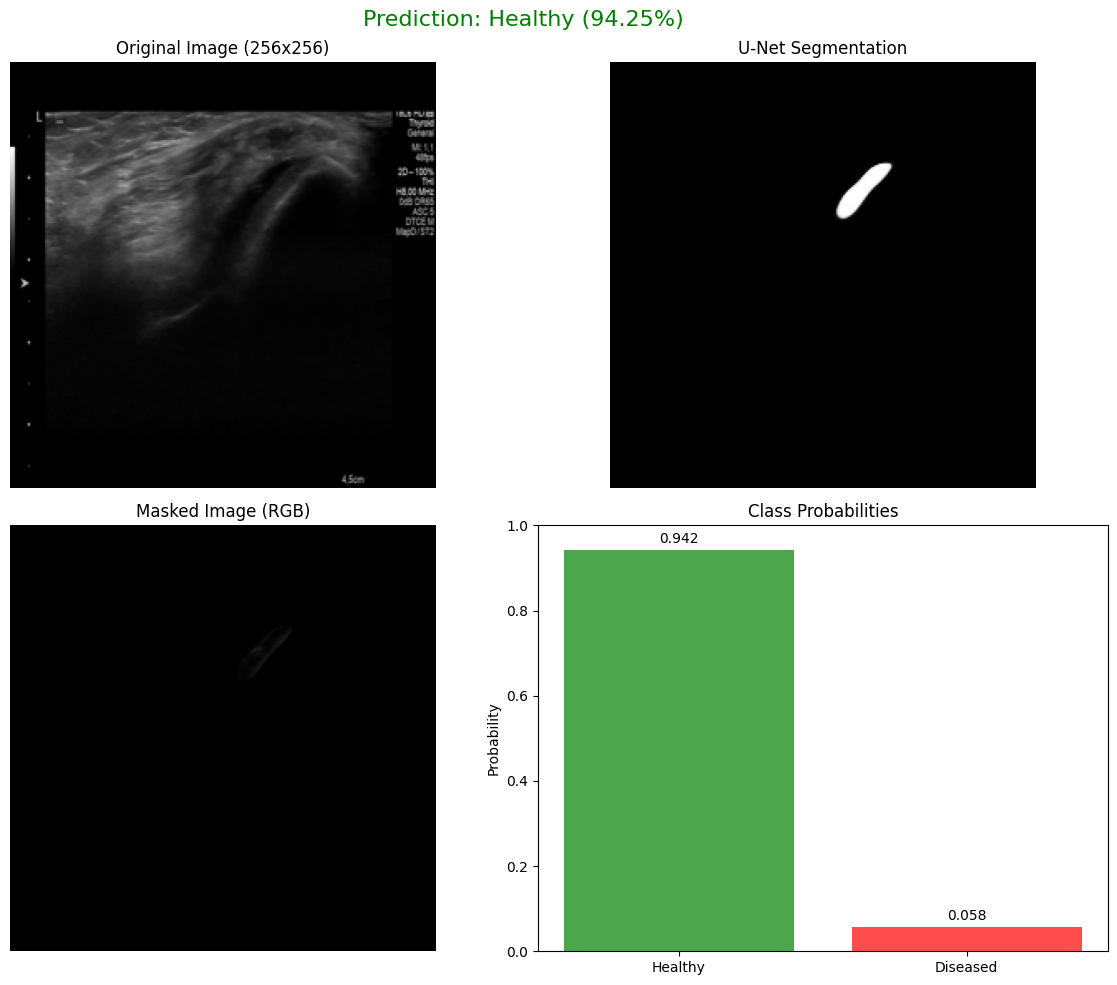


Prediction: Healthy
Confidence: 94.25%
Probability: Healthy=0.942, Diseased=0.058

Final Analysis
Processing: /content/hello.png


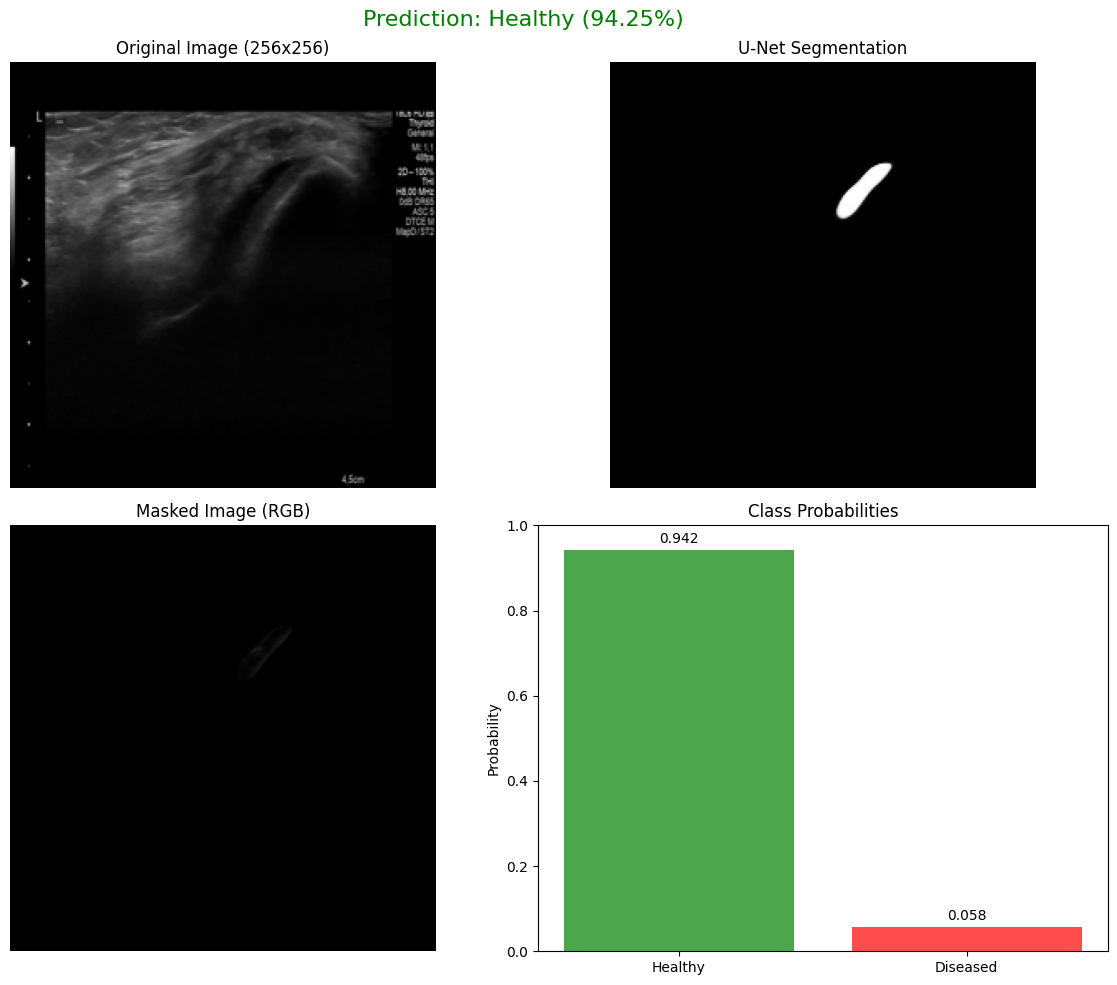


Prediction: Healthy
Confidence: 94.25%
Probability: Healthy=0.942, Diseased=0.058
Processing: /content/hello2.png


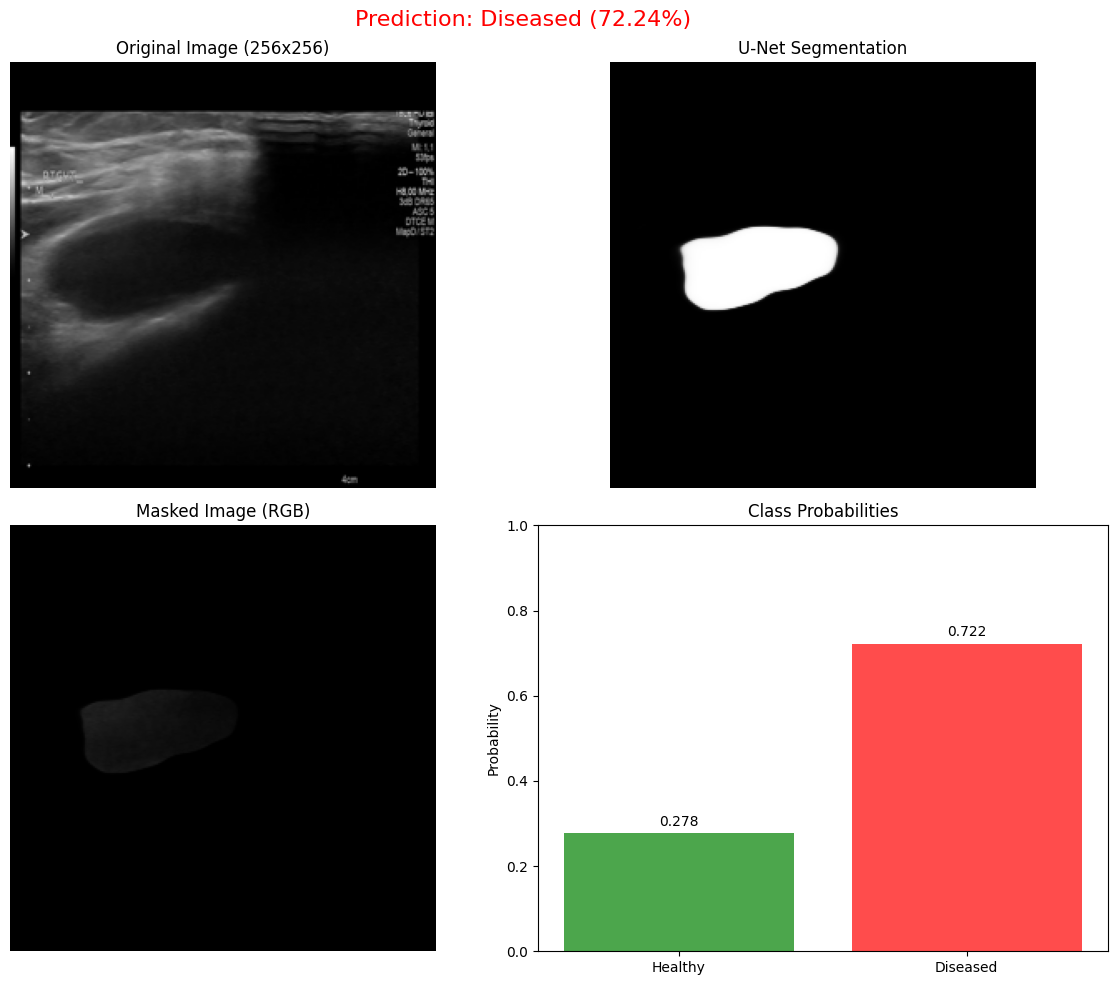


Prediction: Diseased
Confidence: 72.24%
Probability: Healthy=0.278, Diseased=0.722

Prediction Summary
OK! /content/hello.png: Healthy (94.2%)
OK! /content/hello2.png: Diseased (72.2%)


In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D
from PIL import Image
import joblib
import matplotlib.pyplot as plt

#Defining Segmentation Metrics
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

custom_objects = {
    'combined_loss': combined_loss,
    'dice_coefficient': dice_coefficient,
    'dice_loss': dice_loss
}

#Loading Models
unet = load_model("/content/drive/MyDrive/models_kfolds1x/fold_4_best_model.h5", custom_objects=custom_objects)
rf_model = joblib.load("/content/rf_vgg16_classifier_albumentations.pkl")

try:
    scaler = joblib.load("/content/vgg16_scaler_albumentations.pkl")
    print("Scaler loaded successfully")
except:
    print("Warning: Scaler not found!")
    scaler = None

def build_vgg16_feature_extractor():

    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model

feature_extractor = build_vgg16_feature_extractor()


def load_png_image(image_path, size=(256, 256)):

    img = Image.open(image_path).convert("L").resize(size)
    img_array = np.array(img) / 255.0
    return img_array[..., np.newaxis]

def apply_unet_model(image_array):

    input_array = image_array[np.newaxis, ...]
    output = unet.predict(input_array, verbose=0)[0]
    return output

def apply_mask_to_image(image, mask):

    #Normalizing mask if needed
    if mask.max() > 1:
        mask = mask.astype(np.float32) / mask.max()

    #Converting both to RGB
    if len(mask.shape) == 2:
        mask = np.stack([mask] * 3, axis=-1)
    elif len(mask.shape) == 3 and mask.shape[-1] == 1:
        mask = np.repeat(mask, 3, axis=-1)

    if len(image.shape) == 2:
        image = np.stack([image] * 3, axis=-1)
    elif len(image.shape) == 3 and image.shape[-1] == 1:
        image = np.repeat(image, 3, axis=-1)

    #Applying mask
    segmented_image = image * mask
    return segmented_image

def prepare_for_vgg16(image):

    if image.max() <= 1.0:
        image = image * 255.0
    image = image.astype(np.uint8)

    if image.shape[:2] != (224, 224):
        image_pil = Image.fromarray(image)
        image_resized = image_pil.resize((224, 224), Image.LANCZOS)
        image = np.array(image_resized)

    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image.astype(np.float32))

    return image

def extract_vgg16_features(original_image, segmented_mask):

    try:
        #Apply mask to original image
        segmented_image = apply_mask_to_image(original_image.squeeze(), segmented_mask.squeeze())

        #Prepare for VGG16
        processed_image = prepare_for_vgg16(segmented_image)

        #Extract features
        features = feature_extractor.predict(processed_image, verbose=0)

        return features.flatten()

    except Exception as e:
        print(f"Feature extraction error: {e}")
        return None


def debug_pipeline(image_path):

    print(f"=== Debugging for: {image_path} ===")

    original_image = load_png_image(image_path)
    print(f"Original image shape: {original_image.shape}, range: [{original_image.min():.3f}, {original_image.max():.3f}]")

    segmented_mask = apply_unet_model(original_image)
    print(f"Segmented mask shape: {segmented_mask.shape}, range: [{segmented_mask.min():.3f}, {segmented_mask.max():.3f}]")

    masked_image = apply_mask_to_image(original_image.squeeze(), segmented_mask.squeeze())
    print(f"Masked image shape: {masked_image.shape}, range: [{masked_image.min():.3f}, {masked_image.max():.3f}]")

    vgg_input = prepare_for_vgg16(masked_image)
    print(f"VGG16 input shape: {vgg_input.shape}, range: [{vgg_input.min():.3f}, {vgg_input.max():.3f}]")

    features = extract_vgg16_features(original_image, segmented_mask)
    if features is not None:
        print(f"Features shape: {features.shape}, range: [{features.min():.3f}, {features.max():.3f}]")

        if scaler is not None:
            features_scaled = scaler.transform(features.reshape(1, -1))
            print(f"Scaled features range: [{features_scaled.min():.3f}, {features_scaled.max():.3f}]")
            proba = rf_model.predict_proba(features_scaled)[0]
            print(f"Class probabilities: Healthy={proba[0]:.3f}, Diseased={proba[1]:.3f}")
        else:
            print("No scaler available.")
            proba = [0.5, 0.5]
    else:
        print("Feature extraction failed!")
        proba = [0.5, 0.5]

    return original_image, segmented_mask, masked_image, features, proba


def predict_from_path(image_path, debug=False):
    print(f"Processing: {image_path}")

    if debug:
        original_image, segmented_mask, masked_image, features, proba = debug_pipeline(image_path)
    else:
        original_image = load_png_image(image_path)
        segmented_mask = apply_unet_model(original_image)
        features = extract_vgg16_features(original_image, segmented_mask)

        if features is None or scaler is None:
            print("Error in feature extraction or scaler!")
            return "Error", 0.0

        features_scaled = scaler.transform(features.reshape(1, -1))
        proba = rf_model.predict_proba(features_scaled)[0]

        masked_image = apply_mask_to_image(original_image.squeeze(), segmented_mask.squeeze())

    prediction = np.argmax(proba)
    label = "Diseased" if prediction == 1 else "Healthy"
    confidence = proba[prediction] * 100

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    axs[0, 0].imshow(original_image.squeeze(), cmap='gray')
    axs[0, 0].set_title("Original Image (256x256)")
    axs[0, 0].axis("off")

    axs[0, 1].imshow(segmented_mask.squeeze(), cmap='gray')
    axs[0, 1].set_title("U-Net Segmentation")
    axs[0, 1].axis("off")

    axs[1, 0].imshow(masked_image)
    axs[1, 0].set_title("Masked Image (RGB)")
    axs[1, 0].axis("off")

    classes = ['Healthy', 'Diseased']
    colors = ['green', 'red']
    axs[1, 1].bar(classes, proba, color=colors, alpha=0.7)
    axs[1, 1].set_title("Class Probabilities")
    axs[1, 1].set_ylabel("Probability")
    axs[1, 1].set_ylim(0, 1)


    for i, v in enumerate(proba):
        axs[1, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

    plt.suptitle(f"Prediction: {label} ({confidence:.2f}%)",
                fontsize=16, color='green' if label == "Healthy" else 'red')
    plt.tight_layout()
    plt.show()

    print(f"\nPrediction: {label}")
    print(f"Confidence: {confidence:.2f}%")
    print(f"Probability: Healthy={proba[0]:.3f}, Diseased={proba[1]:.3f}")

    return label, confidence


def predict_multiple_images(image_paths):

    results = []

    for image_path in image_paths:
        try:
            label, confidence = predict_from_path(image_path, debug=False)
            results.append({
                'path': image_path,
                'prediction': label,
                'confidence': confidence
            })
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            results.append({
                'path': image_path,
                'prediction': 'Error',
                'confidence': 0.0
            })
    print("\n" + "="*60)
    print("Prediction Summary")
    print("="*60)
    for result in results:
        rstatus = "OK!" if result['prediction'] != 'Error' else "FFFF!"
        print(f"{rstatus} {result['path']}: {result['prediction']} ({result['confidence']:.1f}%)")

    return results


if __name__ == "__main__":
    print("="*60)
    print("Knee Arthiritis Detection")
    print("="*60)

    image_path = "/content/hello.png"

    print("\nPrediction with debug for catching errors:")
    print("-" * 40)
    predict_from_path(image_path, debug=True)

    print("\n" + "="*60)
    print("Final Analysis")
    print("="*60)
    image_paths = [
       "/content/hello.png",
      "/content/hello2.png"
    ]
    results = predict_multiple_images(image_paths)